In [1]:
!pip install plotly==5.5.0

In [131]:
%matplotlib inline

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score,roc_curve, roc_auc_score

In [132]:
data = pd.read_csv('affair_data.csv')
data.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [133]:
X = data[data.columns[:-1]]
Y = data['affair']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0)

In [134]:
model = LogisticRegression()
model.fit(X_train, Y_train)
predictions = model.predict_proba(X_test)

In [142]:
#Альфа версия
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class lazy_roc_auc:
    import numpy as np
    np.seterr(divide='ignore', invalid='ignore')

    _thresholds = np.linspace(0, 1, 1001)
    __y_true =[]
    __y_scores =[]
    __ncalculated = True
    __tps = np.array([]) # True positives
    __fps = np.array([]) # False positives
    __fns = np.array([]) # False negatives
    __tns = np.array([]) # True negatives
    __tprs = np.array([]) # True Positive Rate
    __fprs = np.array([]) # False Positive Rate
    __precisions = np.array([])
    __accuracy = np.array([])
    __f1_scores = np.array([])
    _auc_score = np.array([])  

    def __calc_confusion_matrix(self, threshhold):
        tp = 0 # True positive
        fp = 0 # False positive
        fn = 0 # False negative
        tn = 0 # True negative

        for predicted_prob, actual in zip( self.__y_scores[:,1], self.__y_true ):    
            if predicted_prob >= threshhold:
                predicted = 1
            else:
                predicted = 0
                
            if predicted == 1:
                if actual == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if actual == 1:
                    fn += 1
                else:
                    tn += 1
        return {'tp':tp, 'fp':fp, 'fn':fn, 'tn':tn}
    
    def __calc_basics(self):
        for i in range(self._thresholds.shape[0]):
            result = self.__calc_confusion_matrix(self._thresholds[i])
            self.__tps = self.np.append(self.__tps, result['tp'])
            self.__fps = self.np.append(self.__fps, result['fp'])
            self.__fns = self.np.append(self.__fns, result['fn'])
            self.__tns = self.np.append(self.__tns, result['tn'])

    def __calc_TPR(self):
        self.__tprs = self.__tps / (self.__tps + self.__fns)

    def __calc_FPR(self):
        self.__fprs = self.__fps / (self.__fps + self.__tns)

    def __calc_precisions(self):
        self.__precisions = self.__tps / (self.__tps + self.__fps)
    
    def __calc_accuracy(self):
        self.__accuracy = (self.__tps + self.__tns) / (self.__tps + self.__fps + self.__fns + self.__tns)
    
    def __calc_f1_score(self):
        self.__f1_scores= (self.__precisions * self.__tprs) / (self.__precisions + self.__tprs) *2

    def __calc_auc_score(self):
        n = self._thresholds.shape[0]-1
        dx = 1 / n
        self._auc_score = np.trapz(self.__tprs,x=self.__fprs, dx=dx) * -1

    def __calc_metrics(self):
        self.__calc_TPR()
        self.__calc_FPR()
        self.__calc_precisions()
        self.__calc_accuracy()
        self.__calc_f1_score()
        self.__calc_auc_score()

    def __calculate(self):
        self.__calc_basics()
        self.__calc_metrics()
        self.__ncalculated = False

    def fit(self, y_true,y_scores):
        y_scores = self.np.array(y_scores)
        if(len(y_scores.shape) == 2):
            if(y_scores.shape[1] == 2):
                self.__y_true = self.np.array(y_true)
                self.__y_scores = y_scores
                self.__calculate()
                return
        print('Количество колонок в масиве с предсказаниями меньше или больше двух. \nДанная библиотека расчитана на бинарную класификацию.')

    def __check_data(self, y_true,y_scores):
        if ( (len(y_true) != 0) | (len(y_scores) != 0) ):
            if ( (len(y_true) == 0) | (len(y_scores) == 0) ):
                print('Ошибка в данных. Необходимо заполнить два параметра (y_true, y_scores) или воспользоваться методом fit().')
            else:
                self.fit(y_true, y_scores)      
    
    def plot(self,y_true = '', y_scores=''):
        self.__check_data(y_true, y_scores)
        if(self.__ncalculated):
            return
        fig  = make_subplots(cols=3, rows=1, subplot_titles=("ROC curve", "Precision and Recall vs Threshold", "Precision-Recall curve"))
        fig.add_trace(
            go.Scatter(
                x=self.__fprs,
                y=self.__tprs,
                mode='lines',
                showlegend=False,
                fill='tozeroy',
                customdata = self._thresholds,
                text = self.__accuracy,
                hovertext = self.__f1_scores,
                hovertemplate = '<b>Treshold: %{customdata:.3f}</b><br>' +
                    'False Positive Rate: %{x:.3f}<br>' + 
                    'True Positive Rate: %{y:.3f}<br><br>' + 
                    'Accuracy: %{text:.2f}<br>' +
                    'F1 score: %{hovertext:.2f}',
                #textfont=dict(family="sans serif", size=36, color="crimson")
                #customdata = [self._thresholds, self.__tprs],
                hoverlabel=dict(namelength=0)
            ),
            row = 1,
            col = 1
        )
        fig.add_trace(
            go.Scatter(
                x=[0, 1],
                y=[0, 1],
                mode='lines',
                showlegend=False,
                line = dict(color='gray', width=1, dash='dash'),
                hoverinfo='skip'
            ),
            row = 1,
            col = 1
        )
        fig.add_trace(
            go.Scatter(
                x=self.__precisions,
                y=self.__tprs,
                mode='lines',
                showlegend=False,
                customdata = self._thresholds,
                text = self.__accuracy,
                hovertext = self.__f1_scores,
                hovertemplate = '<b>Treshold: %{customdata:.3f}</b><br>' +
                    'Precission %{y:.3f}<br>' + 
                    'Recall: %{x:.3f}<br><br>' + 
                    'Accuracy: %{text:.2f}<br>' +
                    'F1 score: %{hovertext:.2f}',
                hoverlabel=dict(namelength=0)
            ),
            row = 1,
            col = 3
        )
        fig.add_trace(
            go.Scatter(
                x=self._thresholds,
                y=self.__tprs,
                mode='lines',
                showlegend=False,
                text = self.__accuracy,
                hovertext = self.__f1_scores,
                hovertemplate = '<b>Treshold: %{x:.3f}</b><br>' +
                    'Recall %{y:.3f}<br>' + 
                    'True Positive Rate: %{y:.3f}<br><br>' + 
                    'Accuracy: %{text:.2f}<br>' +
                    'F1 score: %{hovertext:.2f}',
                hoverlabel=dict(namelength=0)
            ),
            row = 1,
            col = 2
        )
        fig.add_trace(
            go.Scatter(
                x=self._thresholds,
                y=self.__precisions,
                mode='lines',
                hovertemplate = 'Precision %{y:.3f}<br>',
                hoverlabel=dict(namelength=0),
                showlegend=False,
            ),
            row = 1,
            col = 2
        )
        fig.update_xaxes(title_text="False Positive Rate", row=1, col=1)
        fig.update_yaxes(title_text="True Positive Rate", row=1, col=1)
        fig.update_xaxes(title_text="Threshold", row=1, col=2)
        fig.update_yaxes(title_text="Precision and Recall", row=1, col=2)
        fig.update_xaxes(title_text="Recall", row=1, col=3)
        fig.update_yaxes(title_text="Precision", row=1, col=3)
        fig.update_xaxes(showspikes=True)
        fig.update_layout(
            template="plotly_dark",
        )
        fig.update_xaxes(showspikes=True, spikesnap="cursor", spikemode="across+toaxis", spikethickness=1, spikedash = 'dash', spikecolor="gray")
        fig.update_yaxes(showspikes=True, spikecolor="gray", spikethickness=1)
        fig.update_layout(hovermode='x', spikedistance=-1)
        #fig.update_layout(hovermode='y', spikedistance=-1)
        fig.add_annotation(x=.7, y=.1,
            text = f"AUC {round(self._auc_score,3)}",
            showarrow=False,
            yshift=10
        )
        fig.update_layout(
            hoverlabel=dict(
                bgcolor='rgba(255,255,255,0.05)',
                namelength = 0,
                font_size = 12,
                font_family="Arial",
                font = dict(color='white'),
                bordercolor = 'rgba(255,255,255,0.05)',
            )
        )
        fig.show()

    def __init__(self,y_true = '', y_scores=''):
        self.__check_data(y_true, y_scores)
        return 

In [143]:
score = lazy_roc_auc(Y_test, predictions )
score.plot()

Из лекции:

AUC: 0.7451629176618145


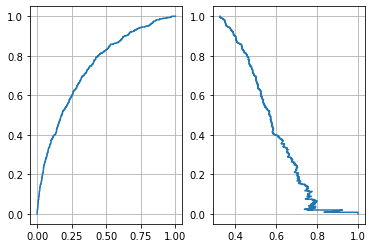

In [144]:
import  matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
fpr, tpr, thres = roc_curve( Y_test, predictions[:, 1] )
pr, re, thres = precision_recall_curve( Y_test, predictions[:, 1] )
print(f"AUC: {roc_auc_score( Y_test, predictions[:, 1] )}")
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot( fpr, tpr )
ax2.plot(pr,re)
ax1.grid()
ax2.grid()

Вроде похоже.